# Scikit-learnの活用

In [36]:
from sklearn import datasets
import numpy as np
# Irisのデータセットをロード
iris = datasets.load_iris()
# 3,4列目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target
# 一意なクラスラベルを出力
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [37]:
# データをさらにトレーニングデータとテストデータに分割する
from sklearn.model_selection import train_test_split
# 全体の30％をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify=y)

** train_test_splitについて **

train_test_splitはデータセットを分割する前に内部でシャッフルする。

乱数シードは**random_state**で指定する。これは分割する前のシャッフルに使用される。

**random_state**パラメータに固定の値を指定すると、シャッフルの仕方が同じになるので再現可能な結果が得られるようになる。

** staratify = y **について
組み込み機能としてサポートされちえる層化サンプリングを利用している。
train_test_splitから返されるトレーニングセットとテストセットに含まれているクラスラベルの比率が入力データセットと同じであることを意味する。
クラスラベルの偏りをなくしてトレーニングセットとテストセットに分けてくれる。
Numpyのbincount関数で確認できる。
配列内の各値の出現回数を数える。

In [38]:
print('Labels counts in y :', np.bincount(y))
# もとのデータセットのｙに[0,1,2]がそれぞれ50個ずつあることがわかる

Labels counts in y : [50 50 50]


In [39]:
print('Labels counts in y :', np.bincount(y_train))
print('Labels counts in y :', np.bincount(y_test))

# testセットもtrainセットも同じ比率で分割していることが確認できた

Labels counts in y : [35 35 35]
Labels counts in y : [15 15 15]


In [40]:
# 特徴量をスケーリングする
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# トレーニングデータの平均と標準偏差を計算
# 特徴量ごとに平均と標準偏差を推定している
sc.fit(X_train)

# 平均と標準偏差を用いて標準化
# 推定された平均と標準偏差を使って、トレーニングデータを標準化している
# testセットもX_trainの平均と標準偏差を使ってスケーリングしていることに注意
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [41]:
# パーセプトロンモデルで分類する
# 1対全(OvR)
from sklearn.linear_model import Perceptron

# エポック数40、学習率0.1でインスタンス作成
ppn = Perceptron(n_iter=40, eta0 = 0.1, random_state=1)# エポックごとにトレーニングデータセットの並び替えを再現できるようにrandom_stateを指定しておく

# トレーニングデータをモデルに適合させる
ppn.fit(X_train_std, y_train)

C:\Users\masayoshi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=None, n_iter=40, n_jobs=1, penalty=None, random_state=1,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [42]:
# predicd メソッドを使って予測を行う
y_pred = ppn.predict(X_test_std)

In [43]:
# 誤分類のサンプルの個数を表示させる
print('Misclassified samples : %d' % (y_test != y_pred).sum())

Misclassified samples : 3


In [44]:
#性能指標の計算にはmetricsモジュールを使う
from sklearn.metrics import accuracy_score
# 分類の正解率を表示
print('Accuracy :%.2f' % accuracy_score(y_test, y_pred))

Accuracy :0.93


In [45]:
# 決定領域をプロットするための関数を作る

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    #マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定域のプロット
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() +1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() +1
    
    #グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    #各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #print(Z)
    
    # 予測結果をもとにグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線プロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[ y == cl, 0], y = X[ y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    
    #テストサンプルを目立たせる（点を〇で表示）
    if test_idx:
        #すべてのサンプルをプロット
        X_test, y_test, = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

In [46]:
"""https://deepage.net/features/numpy-meshgrid.html

In [1]: import numpy as np

In [2]: a = np.array([0, 1, 2])

In [3]: b = np.array([0, 4]) # まずは２つの１次元配列を２つ作る。

In [4]: aa, bb = np.meshgrid(a,b) # 基本的な操作から。

In [5]: aa
Out[5]:
array([[0, 1, 2],
       [0, 1, 2]])

In [6]: bb
Out[6]:
array([[0, 0, 0],
       [4, 4, 4]])

In [7]: c = np.array([0, 9]) # 新たにもう１つ追加する。

In [8]: aaa, bbb, ccc = np.meshgrid(a,b,c) # 3つの軸を持つ配列が３つ生成される。

In [9]: aaa
Out[9]:
array([[[0, 0],
        [1, 1],
        [2, 2]],

       [[0, 0],
        [1, 1],
        [2, 2]]])

In [10]: bbb
Out[10]:
array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[4, 4],
        [4, 4],
        [4, 4]]])

In [11]: ccc
Out[11]:
array([[[0, 9],
        [0, 9],
        [0, 9]],

       [[0, 9],
        [0, 9],
        [0, 9]]])
"""

'https://deepage.net/features/numpy-meshgrid.html\n\nIn [1]: import numpy as np\n\nIn [2]: a = np.array([0, 1, 2])\n\nIn [3]: b = np.array([0, 4]) # まずは２つの１次元配列を２つ作る。\n\nIn [4]: aa, bb = np.meshgrid(a,b) # 基本的な操作から。\n\nIn [5]: aa\nOut[5]:\narray([[0, 1, 2],\n       [0, 1, 2]])\n\nIn [6]: bb\nOut[6]:\narray([[0, 0, 0],\n       [4, 4, 4]])\n\nIn [7]: c = np.array([0, 9]) # 新たにもう１つ追加する。\n\nIn [8]: aaa, bbb, ccc = np.meshgrid(a,b,c) # 3つの軸を持つ配列が３つ生成される。\n\nIn [9]: aaa\nOut[9]:\narray([[[0, 0],\n        [1, 1],\n        [2, 2]],\n\n       [[0, 0],\n        [1, 1],\n        [2, 2]]])\n\nIn [10]: bbb\nOut[10]:\narray([[[0, 0],\n        [0, 0],\n        [0, 0]],\n\n       [[4, 4],\n        [4, 4],\n        [4, 4]]])\n\nIn [11]: ccc\nOut[11]:\narray([[[0, 9],\n        [0, 9],\n        [0, 9]],\n\n       [[0, 9],\n        [0, 9],\n        [0, 9]]])\n'

In [47]:
"""
import numpy as np

# サンプルデータ生成(3 × 3）
> x = np.arange(9).reshape(3, 3)

# 表示
> x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

# 方法1
> x.reshape(-1,)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])


# 方法2
> np.ravel(x)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])
"""

'\nimport numpy as np\n\n# サンプルデータ生成(3 × 3）\n> x = np.arange(9).reshape(3, 3)\n\n# 表示\n> x\n\narray([[0, 1, 2],\n       [3, 4, 5],\n       [6, 7, 8]])\n\n# 方法1\n> x.reshape(-1,)\n\narray([0, 1, 2, 3, 4, 5, 6, 7, 8])\n\n\n# 方法2\n> np.ravel(x)\n\narray([0, 1, 2, 3, 4, 5, 6, 7, 8])\n'

In [48]:
# トレーニングデータとテストデータの特徴量を行方向に結合
X_combind_std = np.vstack((X_train_std, X_test_std) )

In [49]:
# トレーニングデータとテストデータのクラスラベルを結合
y_combind = np.hstack((y_train, y_test)) 

In [50]:
X_combind_std

array([[-1.33269725, -1.30380366],
       [-1.16537974, -1.30380366],
       [ 0.84243039,  1.44465434],
       [ 1.0655204 ,  1.18289644],
       [-1.44424226, -1.30380366],
       [ 1.0097479 ,  1.57553329],
       [ 1.56747294,  1.18289644],
       [-1.44424226, -1.30380366],
       [ 1.12129291,  0.52850167],
       [ 0.45202286,  0.13586482],
       [-0.27301968, -0.25677204],
       [ 0.06161534,  0.26674377],
       [-1.38846976, -1.30380366],
       [ 0.50779537,  0.00498586],
       [ 0.11738784,  0.13586482],
       [ 0.73088538,  0.92113853],
       [-1.05383474, -1.30380366],
       [-0.16147468, -0.25677204],
       [ 0.06161534,  0.00498586],
       [-1.22115225, -1.30380366],
       [ 0.56356787,  0.79025958],
       [ 1.73479045,  1.44465434],
       [ 0.39625036,  0.39762272],
       [ 0.39625036,  0.13586482],
       [ 0.00584283, -0.12589309],
       [ 1.0097479 ,  1.57553329],
       [ 0.50779537,  0.26674377],
       [ 1.0097479 ,  0.26674377],
       [ 1.12129291,

In [51]:
y_combind

array([0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1,
       1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1,
       0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 1,
       1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 2, 0,
       0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1,
       1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0])

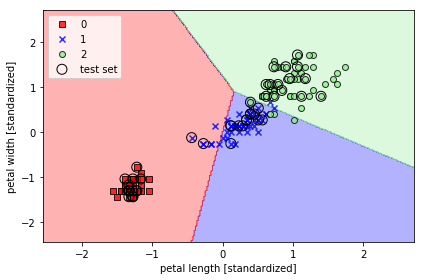

In [52]:
# 決定境界のプロット
plot_decision_regions(X=X_combind_std, y=y_combind, classifier=ppn, test_idx=range(105,150))

#軸ラベルの設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')

#凡例の設定（左上）
plt.legend(loc='upper left')

# グラフの表示
plt.tight_layout()
plt.show()

3つの品種を線形の決定境界で完全に区切ることはできない。

パーセプトロンアルゴリズムは完全な線形分離が不可能なデータセットでは決して収束しない。
そのため、実務のデータ解析で推奨されない。

In [53]:
help(Perceptron)

Help on class Perceptron in module sklearn.linear_model.perceptron:

class Perceptron(sklearn.linear_model.stochastic_gradient.BaseSGDClassifier)
 |  Perceptron
 |  
 |  Read more in the :ref:`User Guide <perceptron>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  penalty : None, 'l2' or 'l1' or 'elasticnet'
 |      The penalty (aka regularization term) to be used. Defaults to None.
 |  
 |  alpha : float
 |      Constant that multiplies the regularization term if regularization is
 |      used. Defaults to 0.0001
 |  
 |  fit_intercept : bool
 |      Whether the intercept should be estimated or not. If False, the
 |      data is assumed to be already centered. Defaults to True.
 |  
 |  max_iter : int, optional
 |      The maximum number of passes over the training data (aka epochs).
 |      It only impacts the behavior in the ``fit`` method, and not the
 |      `partial_fit`.
 |      Defaults to 5. Defaults to 1000 from 0.21, or if tol is not None.
 |  
 |      .. versionadded:: 0.19
 

# シグモイド関数

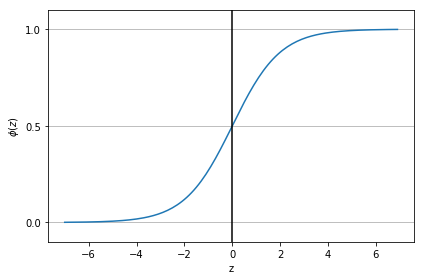

In [54]:
import matplotlib.pyplot as plt
import numpy as np
# シグモイド関数を定義
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# 0.1間隔で-7以上、7未満のデータを生成
z = np.arange(-7, 7, 0.1)

#生成したシグモイド関数を実行
phi_z = sigmoid(z)

# 元のデータとシグモイド関数の出力をプロット
plt.plot(z, phi_z)

# 垂直線を追加
plt.axvline(0.0, color='k')

# y軸の上限下限を設定
plt.ylim(-0.1, 1.1)

# 軸のラベルを設定
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y軸のメモリを追加
plt.yticks([0.0, 0.5, 1.0])

# Axesクラスのオブジェクトの取得
ax = plt.gca()

# y軸の目盛りに合わせて水平グリッド線を追加
ax.yaxis.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

# 対数尤度関数

In [55]:
# sample = 1

# y=1のコストを計算する関数
def cost_1(z):
    return -np.log(sigmoid(z))

# y=0のコストを計算する関数
def cost_0(z):
    return -np.log(1 - sigmoid(z))

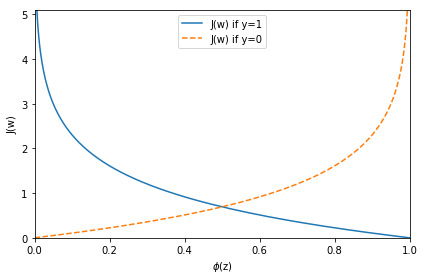

In [56]:
# 0.1間隔で―10以上10未満のデータを生成
z = np.arange(-10, 10, 0.1)
# シグモイド関数を実行
phi_z = sigmoid(z)
# y=1のコストを計算する関数を実行
c1 = [cost_1(x) for x in z]
# 結果をプロット
plt.plot(phi_z, c1, label='J(w) if y=1')
# y=0のコストを計算する関数を実行
c0 = [cost_0(x) for x in z]
# 結果をプロット
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
# x軸とy軸の上限/下限を設定
plt.ylim(0.0, 5.1)
plt.xlim([0,1])
#軸のラベルを設定
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
#凡例を設定
plt.legend(loc = 'upper center')
#グラフを表示
plt.tight_layout()
plt.show()

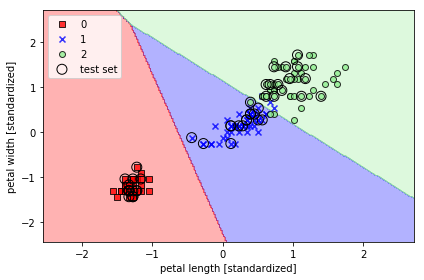

In [57]:
# ADLINE実装をロジスティック回帰のアルゴリズムに変換する
# コスト関数Jをロジスティック回帰のコスト関数Jに置き換えるだけでよい
# scilit-learnで実装してみる

from sklearn.linear_model import LogisticRegression
#ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=100.0, random_state=1)
# トレーニングデータをモデルに適合させる
lr.fit(X_train_std, y_train)
#決定境界をプロット
plot_decision_regions(X_combind_std, y_combind, classifier=lr,
                     test_idx=range(105, 150))

#軸ラベルを設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
#凡例を設定
plt.legend(loc = 'upper left')

#グラフを表示
plt.tight_layout()
plt.show()

In [58]:
lr.predict_proba(X_test_std[:3, :])

array([[  3.20136878e-08,   1.46953648e-01,   8.53046320e-01],
       [  8.34428069e-01,   1.65571931e-01,   4.57896429e-12],
       [  8.49182775e-01,   1.50817225e-01,   4.65678779e-13]])

In [59]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([ 1.,  1.,  1.])

In [60]:
#クラスラベルの予測値を取得するには、各行において最も大きい列を特定すればよい
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [61]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [62]:
lr.predict(X_test_std[0,:].reshape(1,-1))

array([2])

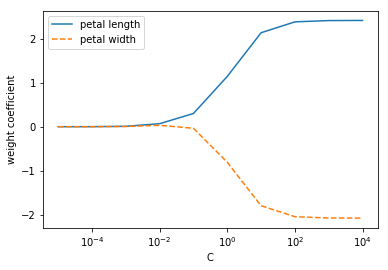

In [63]:
#空のリストを生成（重み係数、逆正則化パラメータ）
weights, params =[],[]
#10個の逆正則化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    #重み係数を格納
    weights.append(lr.coef_[1])
    #逆正則化パラメータを格納
    params.append(10.**c)

#重み係数をNumpy配列に変換
weights = np.array(weights)
#横軸に逆正則化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:,0], label='petal length')
plt.plot(params, weights[:,1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')

#横軸を対数スケールに設定
plt.xscale('log')
plt.show()

# 線形SVM

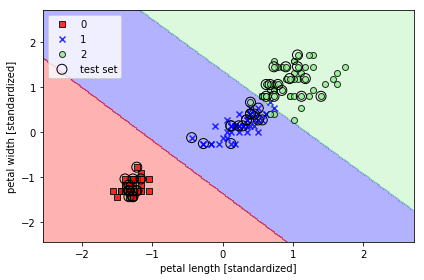

In [64]:
from sklearn.svm import SVC
#線形SVMインスタンスを生成
svm = SVC(kernel='linear', C=1.0, random_state=1)
#線形SVMのモデルにトレーニングデータを適合させる
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combind_std, y_combind, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# カーネルSVM
## カーネル化によって非線形分類の問題を解くことができる

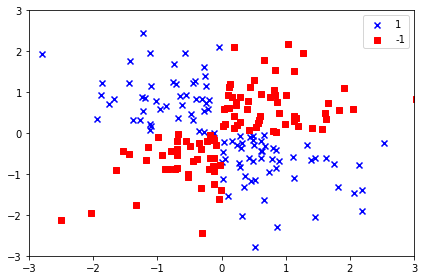

In [65]:
# XORゲート形式の単純なデータセットを作成する。
import matplotlib.pyplot as plt
import numpy as np
#乱数シード
np.random.seed(1)
#標準正規分布に従う乱数で200行2列の行列を生成
X_xor = np.random.randn(200, 2)
# 2つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# 排他的論理和の値が真の場合は1, 偽の場合は‐1を割り当てる
y_xor = np.where(y_xor, 1, -1)
# ラベル１を青のxでプロット
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1],
           c = 'b', marker='x', label='1')
# ラベル-1を赤の四角でプロット
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1],
            c = 'r', marker='s', label='-1')
#軸の範囲を設定
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

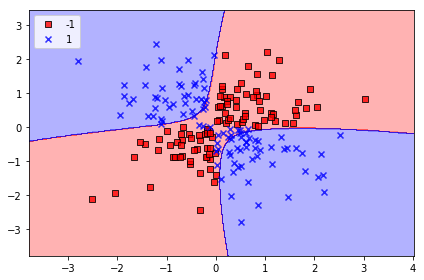

In [66]:
# RBFカーネルによるSVMのインスタンスを生成
svm = SVC(kernel = 'rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

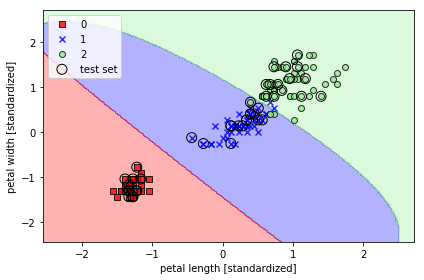

In [69]:
# RBFカーネルによるSVMのインスタンスを生成（2つのパラメータを変更）
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combind_std, y_combind, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

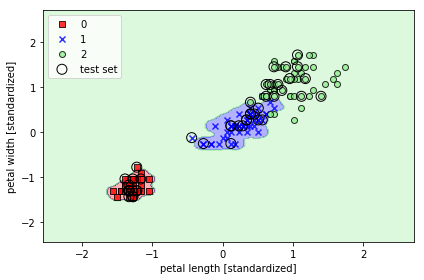

In [71]:
#RBFカーネルによるSVMによるインスタンスを生成(ガンマパラメータを変更)
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combind_std, y_combind, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()